<h1 align="center">Feature Engineering and Building Model</h1>

# 1. Load và kiểm tra dữ liệu

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [97]:
# load lại dữ liệu
df = pd.read_csv('clean_data_10k.csv')


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8636 entries, 0 to 8635
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         8636 non-null   float64
 1   brand         8636 non-null   object 
 2   ram           8636 non-null   float64
 3   ram_type      8635 non-null   object 
 4   display_size  8622 non-null   float64
 5   display_type  8621 non-null   object 
 6   resolution    8622 non-null   object 
 7   screen_rate   2667 non-null   float64
 8   screen_panel  8622 non-null   object 
 9   length        8592 non-null   float64
 10  width         8588 non-null   float64
 11  height        8588 non-null   float64
 12  cpu_brand     8636 non-null   object 
 13  gpu_brand     8636 non-null   object 
 14  ssd           8579 non-null   float64
 15  os            8617 non-null   object 
 16  weight        8636 non-null   float64
 17  cpu_point     7900 non-null   float64
 18  gpu_point     7462 non-null 

# 2. Trích xuất đặc trưng


## 2.1 Định nghĩa hàm đánh giá kết quả trích xuất đặc trưng


In [99]:
# function to calculate mean absolute percentage error to test model with feature engineering
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# function to calculate mean absolute percentage error (MAPE) to test model with feature engineering
def test_model(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, y_pred)


## 2.2 Xử lý và mã hóa dữ liệu dạng category


- Xóa tất cả giá trị nan trong các cột có dạng category


In [100]:
cat_cols = df.select_dtypes(include=['object']).columns
df = df.dropna(subset=cat_cols)
df.select_dtypes(include=['object']).info()


<class 'pandas.core.frame.DataFrame'>
Index: 8601 entries, 0 to 8635
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         8601 non-null   object
 1   ram_type      8601 non-null   object
 2   display_type  8601 non-null   object
 3   resolution    8601 non-null   object
 4   screen_panel  8601 non-null   object
 5   cpu_brand     8601 non-null   object
 6   gpu_brand     8601 non-null   object
 7   os            8601 non-null   object
 8   features      8601 non-null   object
dtypes: object(9)
memory usage: 672.0+ KB


- Xóa các giá trị không chiếm quá 1% tổng số dòng


In [101]:
# remove values that have percentage less than 1% in category columns
for col in cat_cols:
    value_counts = df[col].value_counts(normalize=True)
    to_remove = value_counts[value_counts <= 0.01].index
    # drop rows that have value in to_remove
    df[col].replace(to_remove, np.nan, inplace=True)
    df = df.dropna(subset=[col])


In [102]:
# print value counts of each column that have type object
for col in cat_cols:
    print(df[col].value_counts())


brand
HP        2901
LENOVO    1464
ASUS      1226
MSI        885
DELL       834
ACER       550
LG         133
Name: count, dtype: int64
ram_type
DDR4       6284
DDR5       1256
LPDDR4X     229
LPDDR5      224
Name: count, dtype: int64
display_type
FHD       5381
HD         721
QHD        466
WQXGA      372
HD+        349
WUXGA      323
FHD+       174
4K UHD     113
WQUXGA      94
Name: count, dtype: int64
resolution
1920 x 1080    5381
1366 x 768      721
1920 x 1200     497
2560 x 1600     451
2560 x 1440     387
1600 x 900      349
3840 x 2160     109
3840 x 2400      98
Name: count, dtype: int64
screen_panel
IPS     6446
TN      1431
OLED     116
Name: count, dtype: int64
cpu_brand
INTEL    5599
AMD      2394
Name: count, dtype: int64
gpu_brand
INTEL     3502
NVIDIA    2924
AMD       1567
Name: count, dtype: int64
os
WINDOWS    7993
Name: count, dtype: int64
features
FINGERPRINT READER    6231
WEB CAMERA            1762
Name: count, dtype: int64


In [103]:
# remove OS column cuz it only have 1 value
df = df.drop(columns=['os'])


- Mã hóa one hot cho các cột có dạng category


In [104]:
brand_col = df['brand']
# mã hóa các cột dạng category
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
# replace false by 0 and true by 1 on boolean columns
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].replace({False: 0, True: 1})
df[bool_cols] = df[bool_cols].astype('int64')
# concat brand column
df = pd.concat([df, brand_col], axis=1)
df.shape


(7993, 42)

## 2.3 Chia dữ liệu train và test


In [105]:
trainset, testset = train_test_split(
    df, stratify=df['brand'], test_size=0.2, random_state=2023)


## 2.4 Xử lý dữ liệu trống, xử lý outlier và chuẩn hóa dữ liệu


### 2.4.1 Xử lý dữ liệu trống


- Với các cột numeric, ta sẽ tiến hành fill nan sử dụng IterativeImputer


In [106]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


# apply IterativeImputer to fill numeric columns
def fill_nan_numberics(df):
    # with screen_rate column, we fill nan by 60hz
    df['screen_rate'] = df['screen_rate'].fillna(60)
    # fill ssd column with 0
    df['ssd'] = df['ssd'].fillna(0)
    # get numeric columns that have type float64
    num_cols = df.select_dtypes(include='float64').columns
    imputer = IterativeImputer(max_iter=10, random_state=2023)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    return df


### 2.3.2 Xử lý ngoại lệ với dữ liệu số


In [107]:
from scipy.stats import skew


# xử lý ngoại lệ cho phân bố lệch
def outliers_for_skewed_distribution(df, col):
    res = df.copy()
    q3, q1 = np.percentile(res[col], [75, 25])
    IQR = q3 - q1
    upper_boundary = q3 + 1.5 * IQR
    lower_boundary = q1 - 1.5 * IQR
    res[col][res[col] >= upper_boundary] = upper_boundary
    res[col][res[col] <= lower_boundary] = lower_boundary
    return res


# xử lý ngoại lệ cho phân bố chuẩn
def outliers_for_normal_distribution(df, col):
    res = df.copy()
    q3, q1 = np.percentile(res[col], [75, 25])
    IQR = q3 - q1
    mean = res[col].mean()
    upper_boundary = mean + 1.5 * IQR
    lower_boundary = mean - 1.5 * IQR
    res[col][res[col] >= upper_boundary] = upper_boundary
    res[col][res[col] <= lower_boundary] = lower_boundary
    return res


# function to handle outliers
def handle_outliers(df):
    col_to_handle = df.select_dtypes(include='float64').columns
    # drop price column
    col_to_handle = col_to_handle.drop('price')
    for col in col_to_handle:
        skewness = skew(df[col])
        kurt = df[col].kurtosis()
        # Kiểm tra độ méo lệch và độ nhọn để đánh giá phân bố
        if abs(skewness) < 0.5 and abs(kurt - 3) < 0.5:
            df = outliers_for_normal_distribution(df, col)
        else:
            df = outliers_for_skewed_distribution(df, col)
    return df


### 2.3.3 Chuẩn hóa dữ liệu số


In [108]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer


def standard_scaler(df):
    num_cols = df.select_dtypes(include='float64').columns
    num_cols = num_cols.drop('price')
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df


## 2.5 Xử lý dữ liệu trên tập train và test


In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
pipe_line = Pipeline(steps=[
    ('fill_nan_numberics', FunctionTransformer(fill_nan_numberics)),
    ('handle_outliers', FunctionTransformer(handle_outliers)),
    ('standard_scaler', FunctionTransformer(standard_scaler)),
])


In [110]:
def plot_num_data(df, col):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    sns.histplot(df[col], bins=50, ax=axes[0])
    # plot kde line
    sns.kdeplot(df[col], ax=axes[1])
    sns.boxplot(data=df, x=col, ax=axes[2])
    # plot mean line
    mean = df[col].mean()
    axes[0].axvline(mean, color='r', linestyle='--')
    axes[1].axvline(mean, color='r', linestyle='--')
    # set text size for axes
    for ax in axes:
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        # set labels size
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
    plt.tight_layout()


- Trước khi xử lý

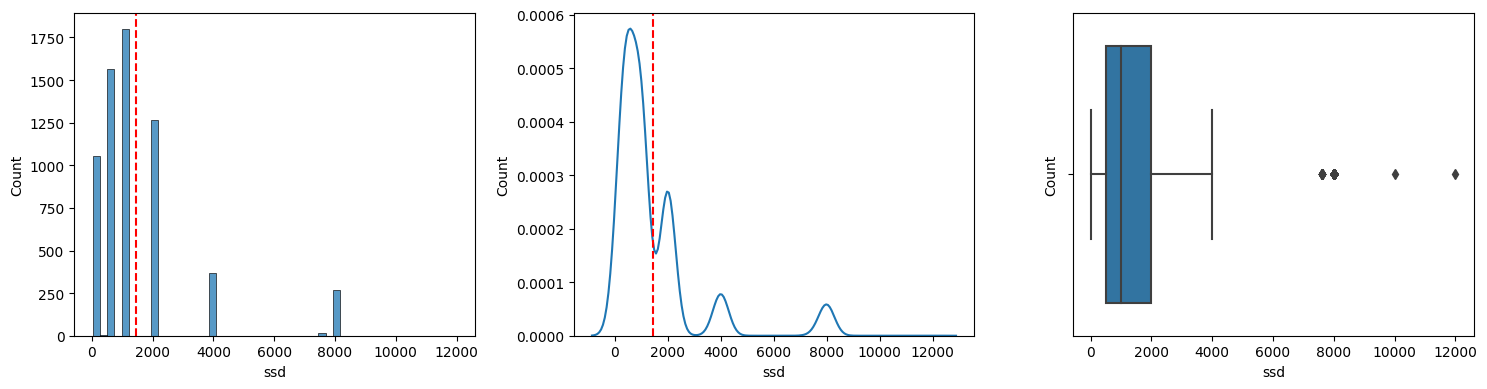

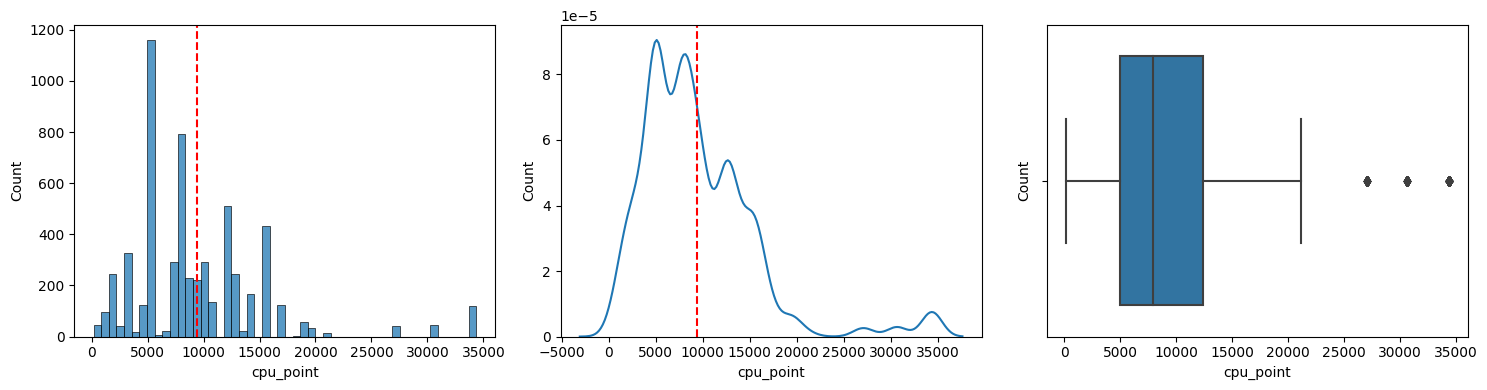

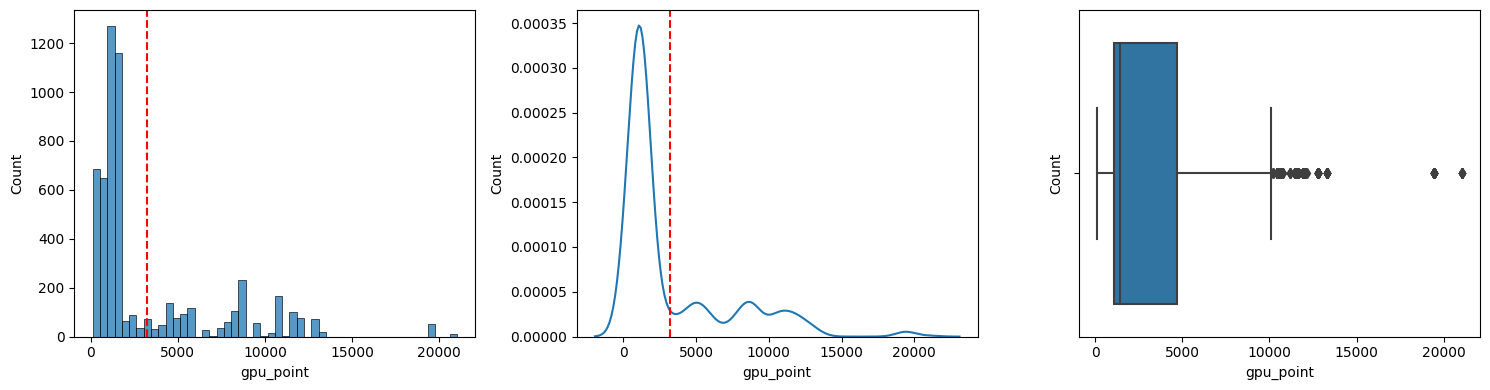

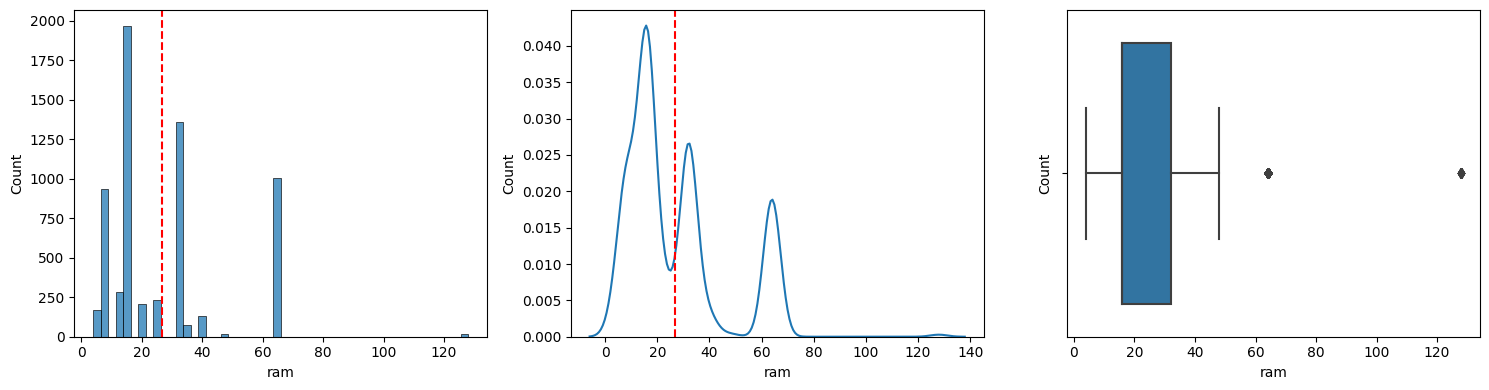

In [111]:
cols = ['ssd', 'cpu_point', 'gpu_point', 'ram']
for col in cols:
    plot_num_data(trainset, col)

In [112]:
trainset = pipe_line.fit_transform(trainset)
testset = pipe_line.transform(testset)
X_train = trainset.drop(columns=['price', 'brand'], axis=1)
y_train = trainset['price']
X_test = testset.drop(columns=['price', 'brand'], axis=1)
y_test = testset['price']

- Sau khi xử lý

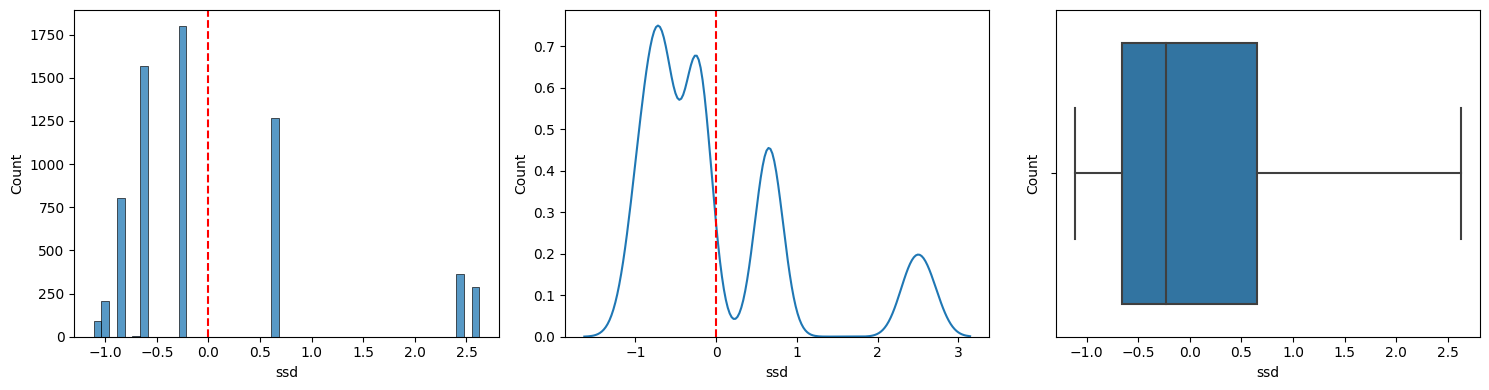

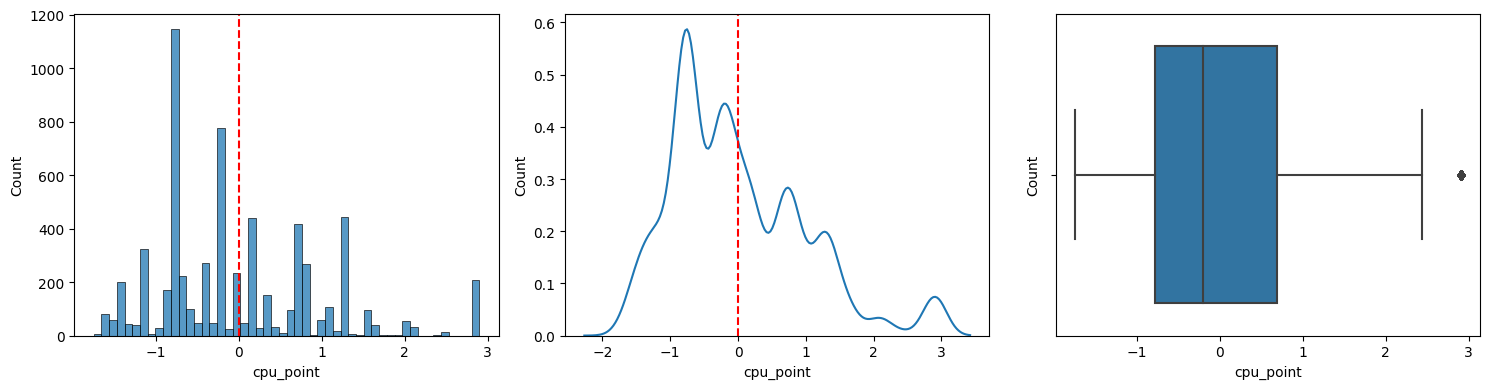

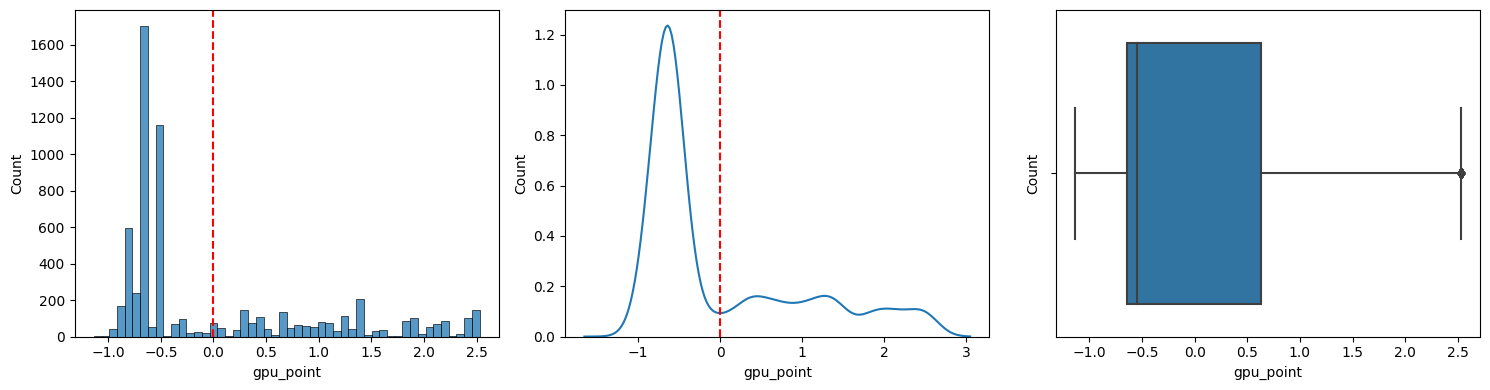

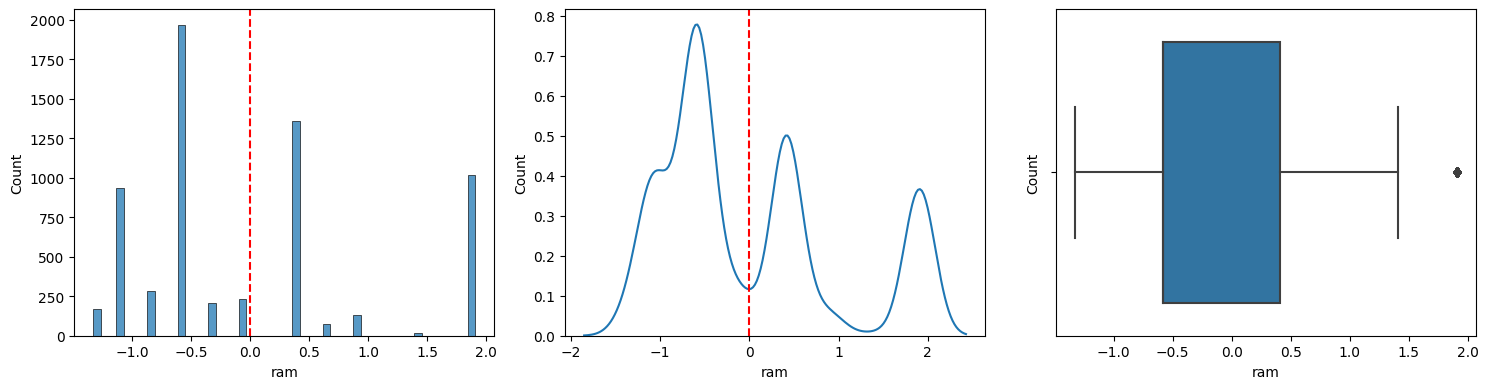

In [113]:
cols = ['ssd', 'cpu_point', 'gpu_point', 'ram']
for col in cols:
    plot_num_data(trainset, col)


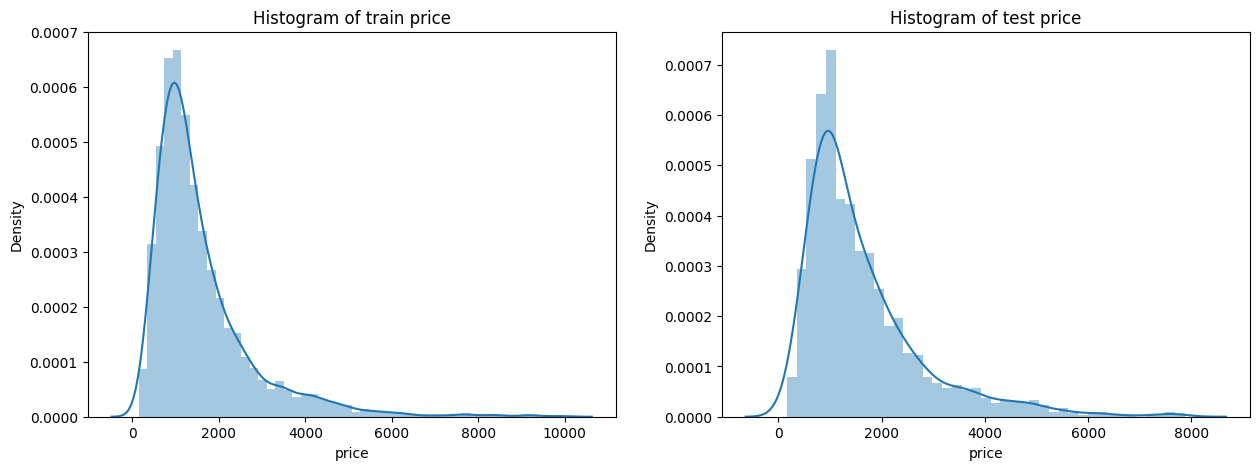

In [114]:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot histogram of price
sns.distplot(y_train, ax=ax[0])
ax[0].set_title('Histogram of train price')
sns.distplot(y_test, ax=ax[1])
ax[1].set_title('Histogram of test price')
plt.show()


## 2.6 Lựa chọn đặc trưng


- Độ chính xác đầu tiên

In [115]:
print("First model MAPE: ", test_model(X_train, X_test, y_train, y_test))

First model MAPE:  0.277490936862905


- Từ tập train, tiếp tục chia thành tập fe_trainset và tập fe_testset để tiến hành lựa chọn đặc trưng

In [116]:

fe_trainset, fe_testset = train_test_split(
    trainset, stratify=trainset['brand'], test_size=0.2, random_state=2023)

fe_trainset.drop(['brand'], axis=1, inplace=True)
fe_testset.drop(['brand'], axis=1, inplace=True)

fe_X_train = fe_trainset.drop(['price'], axis=1)
fe_y_train = fe_trainset['price']
fe_X_test = fe_testset.drop(['price'], axis=1)
fe_y_test = fe_testset['price']


In [117]:
print("MAPE with orginal trainset: ", test_model(fe_X_train, fe_X_test, fe_y_train, fe_y_test))

MAPE with orginal trainset:  0.2730871161923343


### 2.6.1 Sử dụng độ tương quan


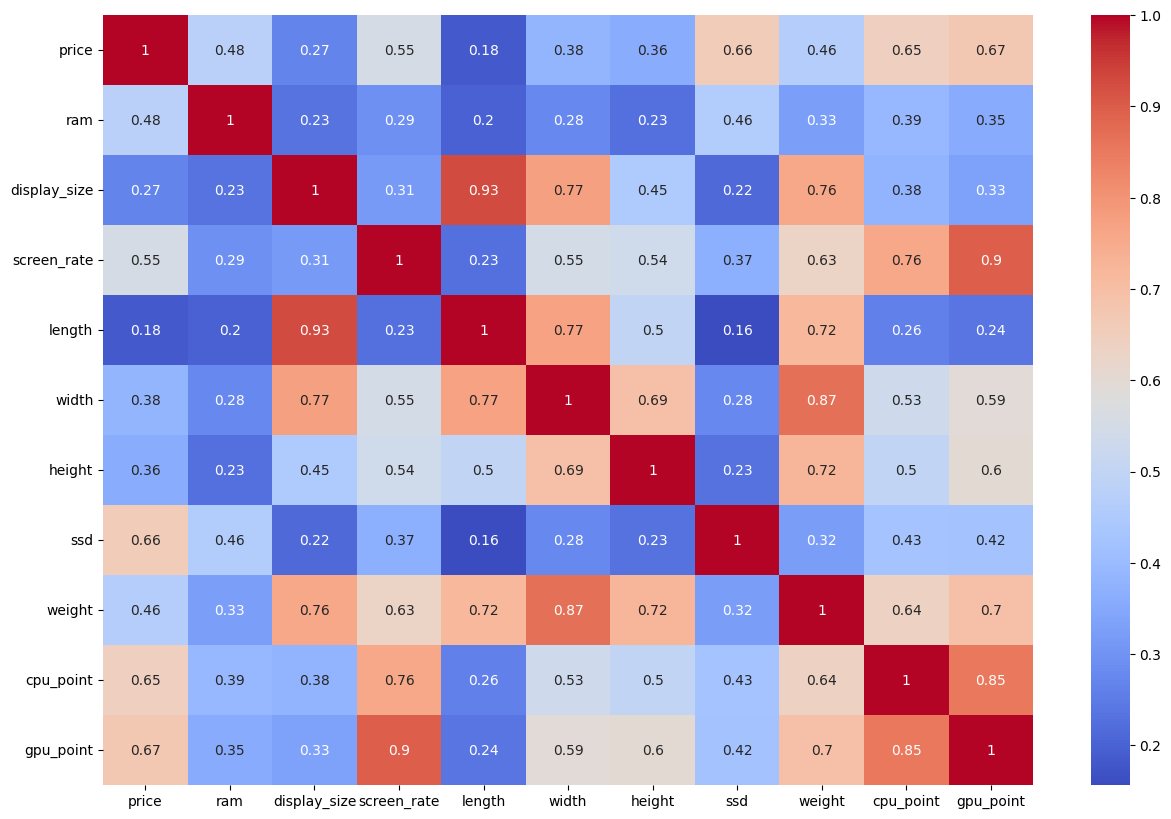

In [118]:
# get numeric columns that have type float64
num_cols = trainset.select_dtypes(include='float64').columns
# plot correlation matrix
corr = trainset[num_cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

- Ý tưởng: lần lượt duyệt và tính độ lỗi dựa trên độ tương quan của các đặc trưng từ có độ tương quan từ cao đến thấp với cột price

In [119]:
def corr_feature_selection(X_train, X_test, y_train, y_test):
    df = pd.concat([X_train, y_train], axis=1)
    err_list = []
    for i in range(2, len(X_train.columns) + 2):
        best_col = df.corr()['price'].sort_values(ascending=False).head(i)
        best_col = best_col.drop('price')
        feat_col = best_col.index
        err = test_model(X_train[feat_col], X_test[feat_col], y_train, y_test)
        err_list.append((i, err))
        # print("Corr err with ", i-1, "feats:", err)
    return err_list

Min error: 0.2730746200425006 with 40 features


Text(0.5, 1.0, 'Corr selected features')

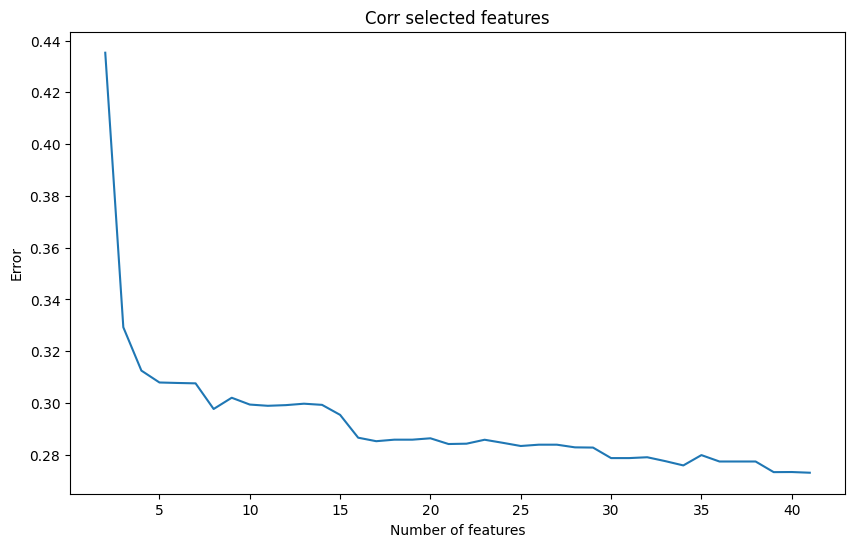

In [120]:

# err_corr = corr_feature_selection(fe_X_train, fe_X_test, fe_y_train, fe_y_test)
err_corr = corr_feature_selection(fe_X_train, fe_X_test, fe_y_train, fe_y_test)
min_err = min(err_corr, key=lambda x: x[1])
print("Min error:", min_err[1], "with", min_err[0]-1, "features")

plt.figure(figsize=(10, 6))
plt.plot(*zip(*err_corr))
plt.xlabel('Number of features')
plt.ylabel('Error')
plt.title('Corr selected features')


- Kết quả: không giảm được số đặc trưng và không cải thiện được độ lỗi quá nhiều

### 2.6.2 PCA


- Ý tưởng: sử dụng PCA để giảm số chiều của dữ liệu, với số chiều chạy từ 1 đến số cột của dữ liệu

In [121]:
from sklearn.decomposition import PCA


def pca_feature_selection(X_train, X_test, y_train, y_test):
    err_list = []
    for i in range(1, len(X_train.columns) + 1):
        pca = PCA(n_components=i)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        error = test_model(X_train_pca, X_test_pca, y_train, y_test)
        err_list.append((i, error))
    return err_list


Min error: 0.2709576314242234 with 31 dimensions


Text(0.5, 1.0, 'PCA selected features')

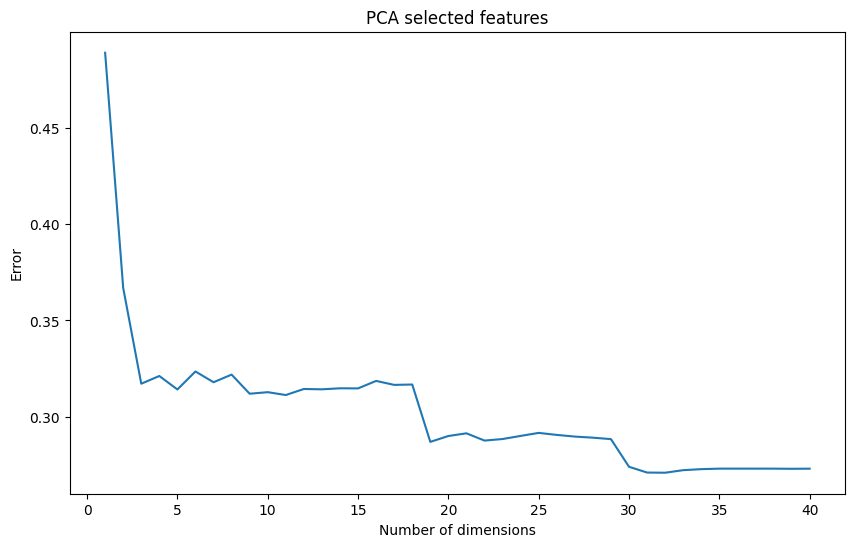

In [122]:

err_pca = pca_feature_selection(fe_X_train, fe_X_test, fe_y_train, fe_y_test)
# print min error and number of features that give min error
min_err2 = min(err_pca, key=lambda x: x[1])
print("Min error:", min_err2[1], "with", min_err2[0]-1, "dimensions")

plt.figure(figsize=(10, 6))
plt.plot(*zip(*err_pca))
plt.xlabel('Number of dimensions')
plt.ylabel('Error')
plt.title('PCA selected features')


- Kết quả cải thiện từ 0,273 -> 0,270
- Kết quả độ lỗi thấp nhất với số chiều là 31

### 2.6.3 RFE


In [123]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def rfe_feature_selection(X_train, X_test, y_train, y_test):
    err_list = []
    for i in range(1, len(X_train.columns) + 1):
        rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
        rfe.fit(X_train, y_train)
        X_train_rfe = rfe.transform(X_train)
        X_test_rfe = rfe.transform(X_test)
        error = test_model(X_train_rfe, X_test_rfe, y_train, y_test)
        err_list.append((i, error))
    return err_list


Min error: 0.27294890813665845 with 37 features


Text(0.5, 1.0, 'RFE selected features')

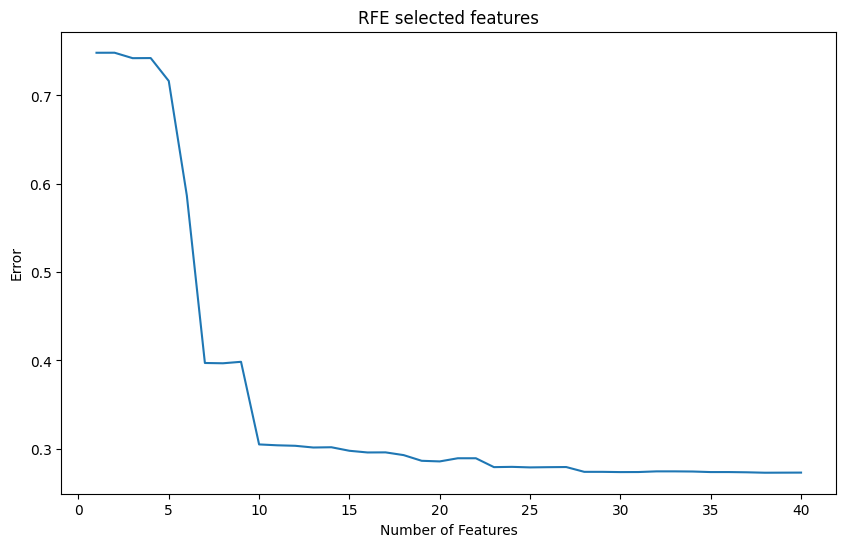

In [124]:
# print min error and number of features that give min error
err_rfe = rfe_feature_selection(fe_X_train, fe_X_test, fe_y_train, fe_y_test)
min_err3 = min(err_rfe, key=lambda x: x[1])
print("Min error:", min_err3[1], "with", min_err3[0]-1, "features")
# plot error list
plt.figure(figsize=(10, 6))
plt.plot(*zip(*err_rfe))
plt.xlabel('Number of Features')
plt.ylabel('Error')
plt.title('RFE selected features')


- Không cải thiện được độ lỗi

# 3. Mô hình hóa


## 3.1 Chuẩn bị dữ liệu huấn luyện


Chọn PCA với số chiều dữ liệu là 31


In [125]:
pca = PCA(n_components=31)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# convert X_train_pca to dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


## 3.2 Mô hình Linear Regression


In [126]:
# define model Linear Regression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import math
import seaborn as sns


class ModelLinearRegression:
    """
    Class Model:
    Linear Regression's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    ---------------------
    Properties:
        model_pipeline: contain preprocessing pipeline + model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self, preprocessing_pipeline):
            Initialize the model pipeline.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """

    def __init__(self):
        self.model = LinearRegression()

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred

    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)

        print('MAE: {}'.format(self.score_mae))
        print('RMSE: {}'.format(self.score_rmse))
        print('MAPE: {}'.format(self.score_mape))

        return self.score_mae, self.score_rmse, self.score_mape

    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=np.arange(
            0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=np.arange(
            0, X_test[:, 0].shape[0]), y=y_test, ax=ax, color='orange', label='Ground truth')

        ax.set_title(
            f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()


MAE: 428.17405299991213
RMSE: 625.9793413854309
MAPE: 0.2775172642489963


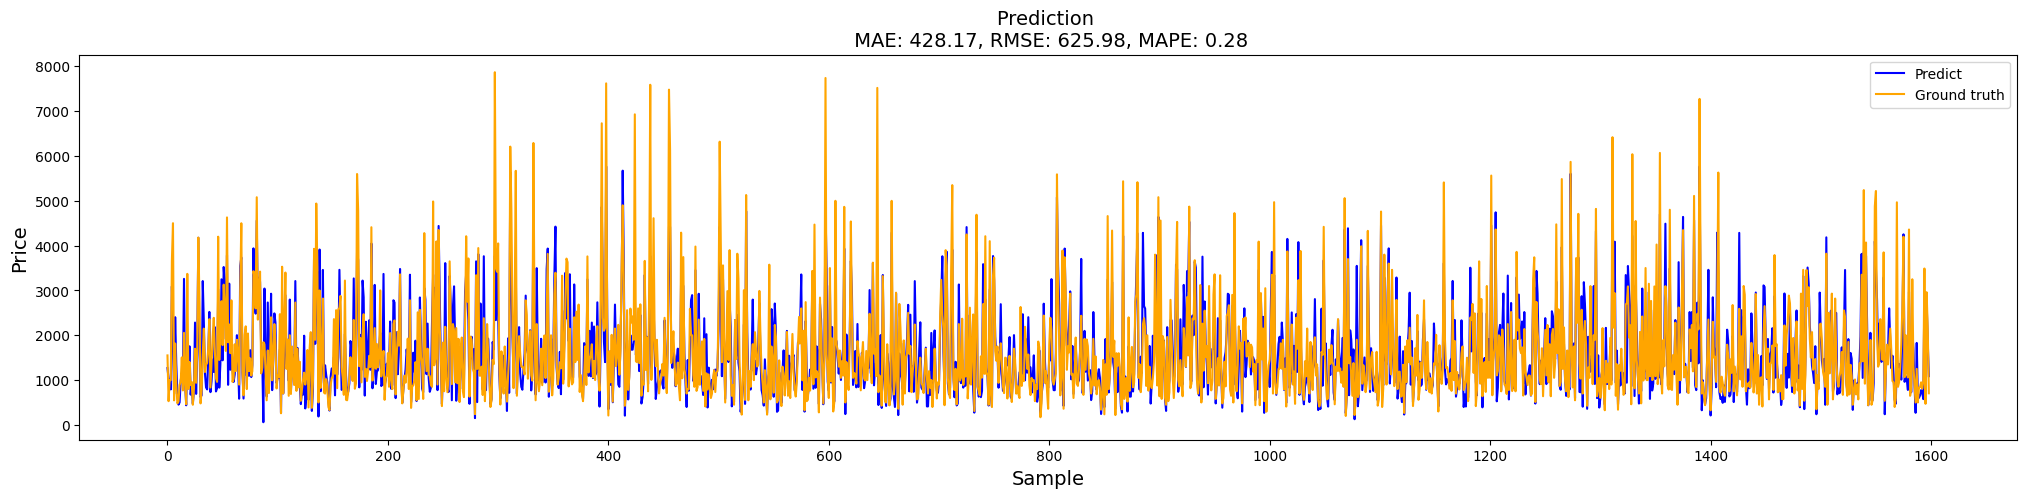

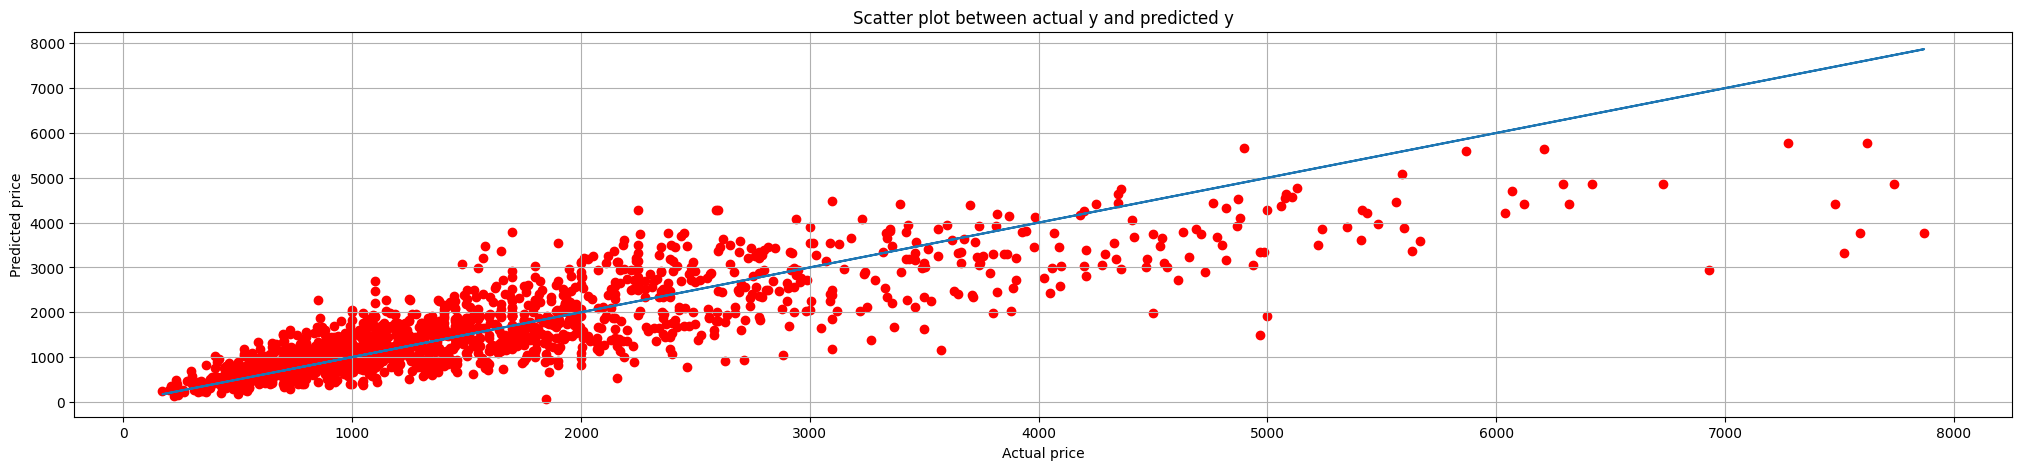

In [127]:
# Define model
linear_reg = ModelLinearRegression()

# Train model
linear_reg.train(X_train, y_train)

# Make prediction
linear_y_pred = linear_reg.predict(X_test)

# Evaluate model
linear_score_mae, linear_score_rmse, linear_score_mape = linear_reg.evaluate(y_test, linear_y_pred)

# Visualize metrics
linear_reg.plot_result(25, 5, X_test.values, y_test)
linear_reg.plot_yy(25, 5, linear_y_pred, y_test)


## 3.3 Mô hình Support Vector Regression


- Idea: Fit as many instances as possible on the street line while limiting the margin violations


In [128]:
from sklearn.svm import LinearSVR
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV


class ModelSVR:
    """
    Class Model:
    Linear Support Vector Regression's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html
    ---------------------
    Properties:
        model: Linear Support Vector Regression model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self, preprocessing_pipeline):
            Initialize the model pipeline.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred) -> tuple(float):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """

    def __init__(self):
        self.model = LinearSVR()

    def train(self, X_train, y_train):
        # Using randomized search CV technique to find the best hyperparameter for the linear svr model

        # Define the hyperparameter grid
        param_grid = {
            # Range of values for the C parameter
            'C': uniform(0.1, 10),
            # Range of values for the epsilon parameter
            'epsilon': uniform(0.01, 1)
        }

        rnd_search = RandomizedSearchCV(self.model, scoring="neg_root_mean_squared_error",
                                        param_distributions=param_grid, n_iter=100, random_state=42)
        rnd_search.fit(X_train, y_train)
        print("SVR Randomize score: " + str(rnd_search.best_score_))
        print("SVR GridSearch params: ")
        print(rnd_search.best_params_)

        self.model = rnd_search.best_estimator_

    def predict(self, X_test):
        self.y_pred = self.model.predict(X_test)
        return self.y_pred

    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)

        print('MAE: {}'.format(self.score_mae))
        print('RMSE: {}'.format(self.score_rmse))
        print('MAPE: {}'.format(self.score_mape))

        return self.score_mae, self.score_rmse, self.score_mape

    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(
            0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=y_test,
                     ax=ax, color='orange', label='Ground truth')

        ax.set_title(
            f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()


SVR Randomize score: -730.6921150694769
SVR GridSearch params: 
{'C': 9.724472949421111, 'epsilon': 0.26178229582536416}
MAE: 423.1346538428011
RMSE: 691.8360706907957
MAPE: 0.24018547148502079


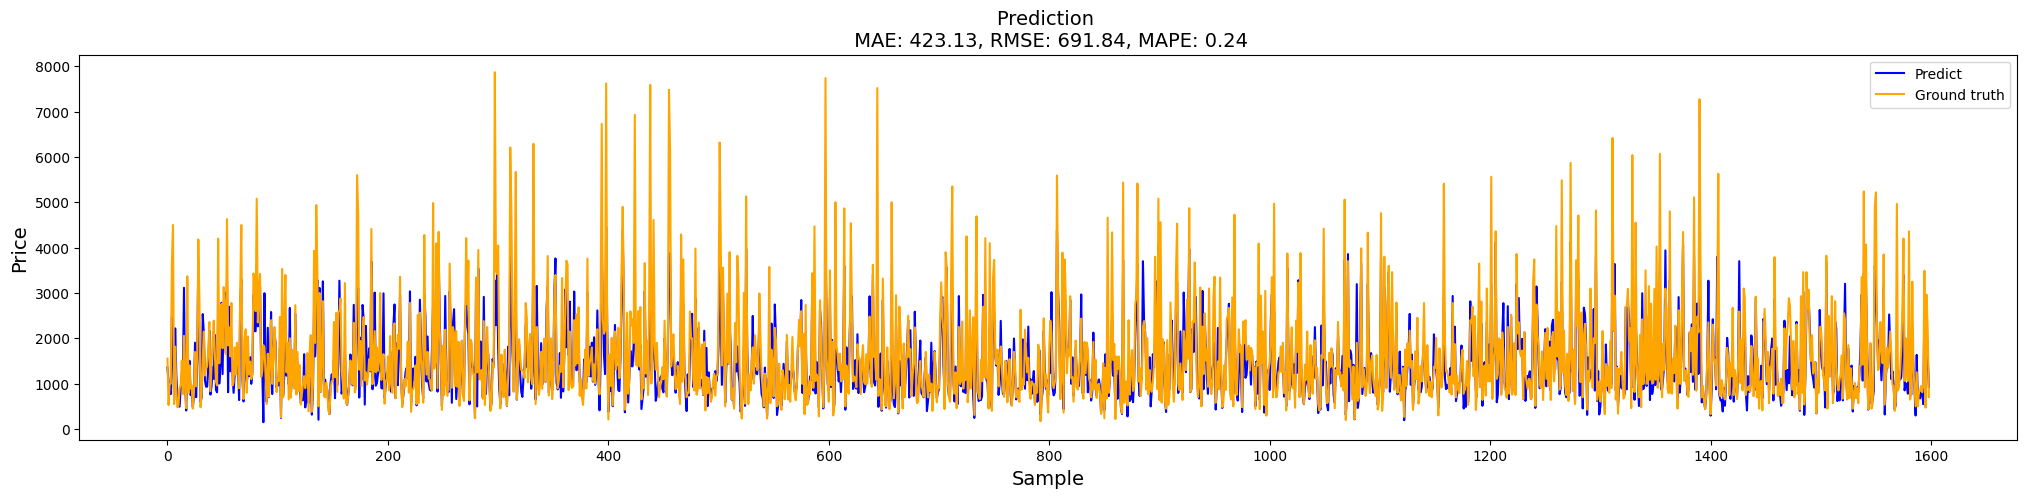

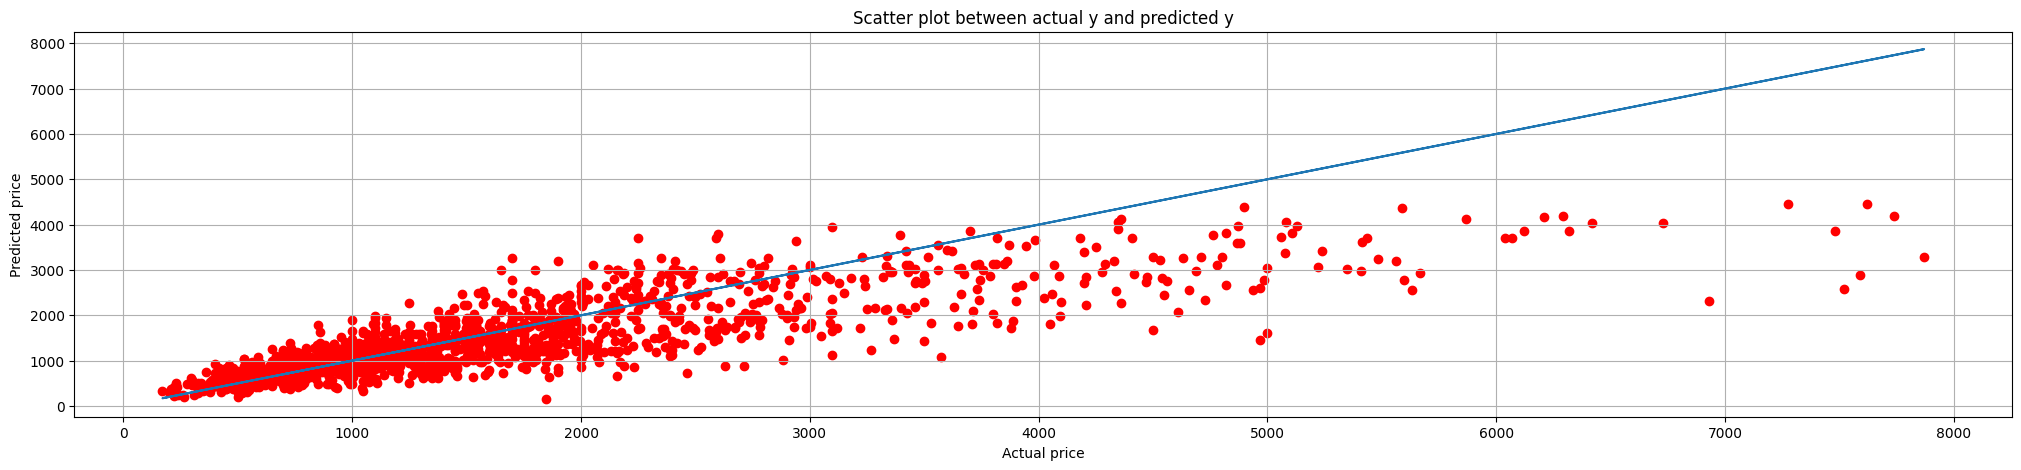

In [129]:
# Define model
svr_reg = ModelSVR()

# Train model
svr_reg.train(X_train, y_train)

# Make prediction
svr_y_pred = svr_reg.predict(X_test)

# Evaluate model
svr_score_mae, svr_score_rmse, svr_score_mape = svr_reg.evaluate(
    y_test, svr_y_pred)

# Plot results
svr_reg.plot_result(25, 5, X_test.values, y_test)
svr_reg.plot_yy(25, 5, svr_y_pred, y_test)
